In [3]:
! ls -l /g/data/w97/ad9701/drought_2017to2020/precip_data/SPI3_baseline_198101_202005/

total 9290616
-rw-r--r--. 1 ad9701 w97 1650786188 Mar 23  2022 SPI3_agcd_monthly_1981_2020_set1.nc
-rw-r--r--. 1 ad9701 w97 1654716596 Mar 23  2022 SPI3_agcd_monthly_1981_2020_set2.nc
-rw-r--r--. 1 ad9701 w97 1655641396 Mar 23  2022 SPI3_agcd_monthly_1981_2020_set3.nc
-rw-r--r--. 1 ad9701 w97 1659583364 Mar 23  2022 SPI3_agcd_monthly_1981_2020_set4.nc
-rw-r--r--. 1 ad9701 w97 2248259828 Mar 23  2022 SPI3_chirps_monthly_1981_2021.nc
-rwxr-xr-x. 1 ad9701 w97  580349892 Mar 23  2022 SPI3_mswep_monthly_1981_2020.nc
-rw-r--r--. 1 ad9701 w97       3600 Apr  1  2022 spi_calc_gridded_agcd.R
-rw-r--r--. 1 ad9701 w97   21766589 Apr  1  2022 spi_list_dry_byyear.pickle
-rw-r--r--. 1 ad9701 w97   21766796 Apr  1  2022 spi_list_dry_JJAS_byyear.pickle
-rw-r--r--. 1 ad9701 w97   10336231 Apr  1  2022 spi_list_dry_JJAS.pickle
-rw-r--r--. 1 ad9701 w97   10336329 Apr  1  2022 spi_list_dry.pickle


In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle
import geopandas as gpd
%run -i Tinderbox_drought/drought_metrics/dataInfo_and_functions.py

In [5]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/precip_data/SPI3_baseline_198001_201612/'

out_dir = 'figures/drought_2017to2020/precip/baseline_198001_201612/'
figname_prefix = 'spi_3m'
fname_prefix = 'spi_3m'
vname = 'SPI3'

time_slice = slice('2017-01-01', '2020-12-31')

filename = glob.glob(data_dir + 'SPI3_agcd_monthly*.nc')
ds_agcd = xr.open_mfdataset(filename)
ds_agcd = ds_agcd.sel(time = time_slice)

filename = glob.glob(data_dir + 'SPI3_mswep_monthly*.nc')[0]
ds_mswep = xr.open_dataset(filename)
ds_mswep = ds_mswep.sel(time = time_slice)

filename = glob.glob(data_dir + 'SPI3_chirps_monthly*.nc')[0]
ds_chirps = xr.open_dataset(filename)
ds_chirps = ds_chirps.sel(time = time_slice)

data_name_2 = ['mswep', 'agcd', 'chirps']
mask_list = []
for d in data_name_2:
    ds_mask = xr.open_dataset('/g/data/w97/ad9701/drought_2017to2020/precip_data/' + d + '_land_mask.nc')
    mask_list.append(ds_mask['land_mask'])
    
fig_dir = 'figures/drought_2017to2020/precip/baseline_198001_201612/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [7]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/566/ad9701/drought_2017to2019/dataInfo_and_functions.py:396: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(out_dir + out_figname + '.' + fig_format, format = fig_format, dpi = fig_dpi, rasterized = True, bbox_inches='tight')
/home/566/ad9701/drought_2017to2019/dataInfo_and_functions.py:396: MatplotlibDeprecationWarning: savefig() got unexpected

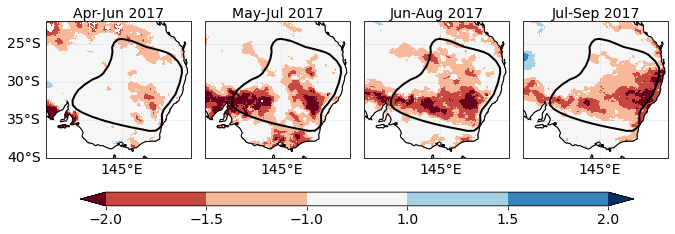

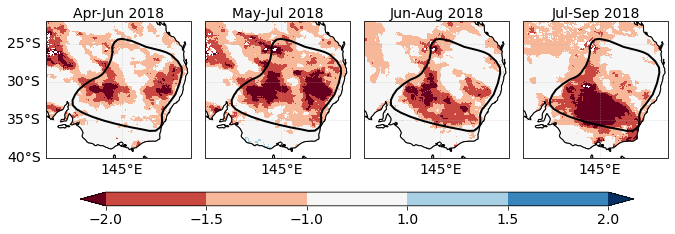

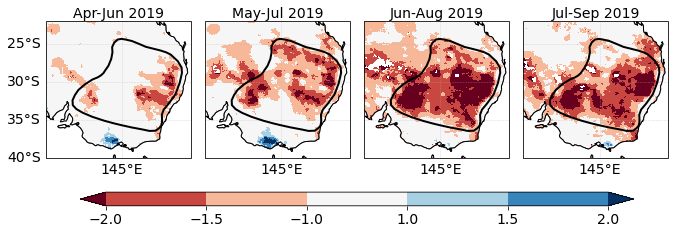

In [7]:
# MSWEP is at the coarest resolution; regrid AGCD and CHIRPS to the MSWEP grid

da_agcd_chirps_reg = regrid_all_from_list([ds_agcd['SPI3'], ds_chirps['SPI3']], lat = ds_mswep['SPI3'].lat.values, lon = ds_mswep['SPI3'].lon.values)

da_agcd_chirps_reg[0].load()
da_agcd_chirps_reg[1].load()
ds_mswep['SPI3'].load()

# plot mean SPI3
cmap = 'RdBu'
levels = [-2, -1.5, -1, 1, 1.5, 2]

out_dir = 'figures/drought_2017to2020/precip/baseline_198001_201612/'
sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

lat_slice = slice(-40, -20)
lat_slice_rev = slice(-20, -40)
lon_slice = slice(135, 154)

monName_list = ['Apr-Jun', 'May-Jul', 'Jun-Aug', 'Jul-Sep']

for yrStr in ['2017', '2018', '2019']:
    time_slice = slice(yrStr + '-06-01', yrStr + '-09-30')
    
    da_sel_list = []
    for da in [da_agcd_chirps_reg[0], da_agcd_chirps_reg[1], ds_mswep['SPI3']]:
        da_temp = da.sel(time = time_slice, lat = lat_slice_rev, lon = lon_slice)
        time_arr = da_temp.time.values.astype('datetime64[M]')
        da_temp = da_temp.assign_coords({'time':time_arr})
        da_sel_list.append(da_temp)
        del da_temp
        
    subplot_title = [x + ' ' + yrStr for x in monName_list]    
    da_avg = (da_sel_list[0] + da_sel_list[1] + da_sel_list[2])/3
    out_figname = 'spi3_dataMean_' + yrStr + '.png'
    plot_list = [da_avg.isel(time = i) for i in range(4)]
    plot_obj = draw_pcolormesh_Npanels(plot_list, cmap = cmap, ncols = 4, nrows = 1, panel_width=2.4, panel_height=3.8, levels=levels, 
                                              shapefile = sh_file, shapefile_color = 'black', subplot_title = subplot_title,
                                              cbar_label='', longer_cbar = True, thicker_cbar=True, out_dir = out_dir, out_figname = out_figname, fig_dpi = 600)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


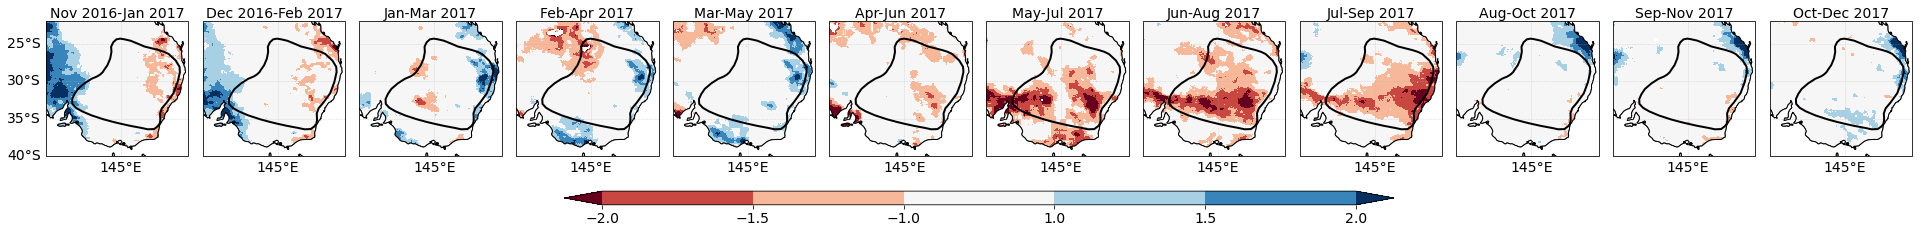

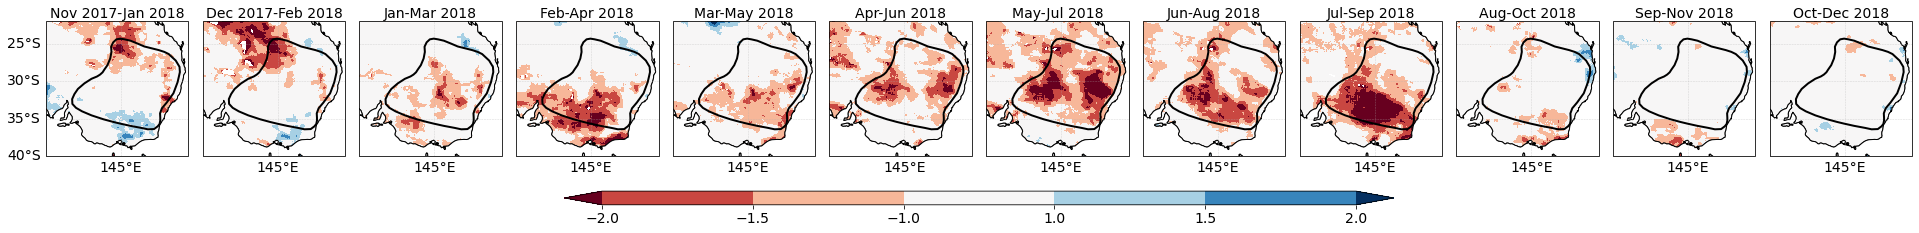

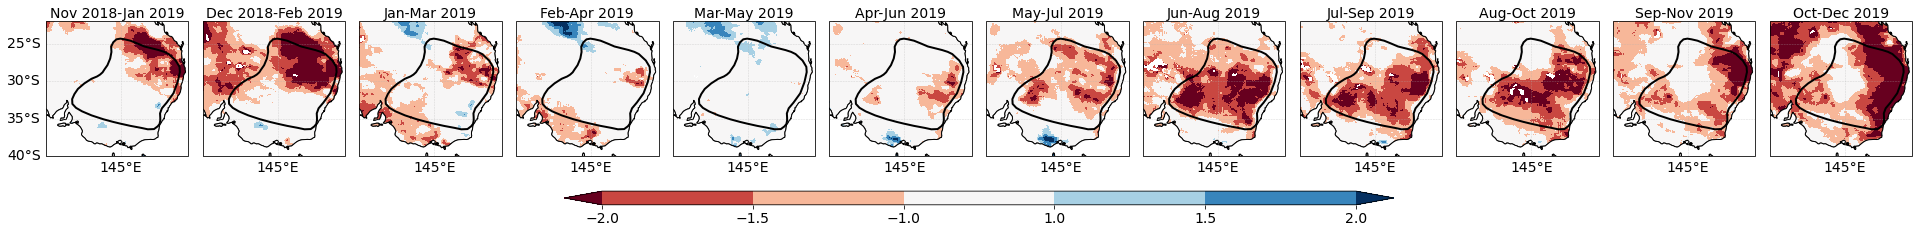

In [8]:
# plot data for all months

da_agcd_chirps_reg = regrid_all_from_list([ds_agcd['SPI3'], ds_chirps['SPI3']], lat = ds_mswep['SPI3'].lat.values, lon = ds_mswep['SPI3'].lon.values)

da_agcd_chirps_reg[0].load()
da_agcd_chirps_reg[1].load()
ds_mswep['SPI3'].load()

# plot mean SPI3
cmap = 'RdBu'
levels = [-2, -1.5, -1, 1, 1.5, 2]

out_dir = 'figures/drought_2017to2020/precip/baseline_198001_201612/'
sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'

lat_slice = slice(-40, -20)
lat_slice_rev = slice(-20, -40)
lon_slice = slice(135, 154)

monName_list = ['Jan-Mar', 'Feb-Apr', 'Mar-May', 'Apr-Jun', 'May-Jul', 'Jun-Aug', 'Jul-Sep', 'Aug-Oct', 'Sep-Nov', 'Oct-Dec']

prefixTitle_lists = [['Nov 2016-Jan 2017', 'Dec 2016-Feb 2017'],
                     ['Nov 2017-Jan 2018', 'Dec 2017-Feb 2018'],
                     ['Nov 2018-Jan 2019', 'Dec 2018-Feb 2019']]    
                     
for i, yrStr in zip(range(3), ['2017', '2018', '2019']):
    # time_slice = slice(yrStr + '-06-01', yrStr + '-09-30')
    time_slice = slice(yrStr, yrStr)
    
    da_sel_list = []
    for da in [da_agcd_chirps_reg[0], da_agcd_chirps_reg[1], ds_mswep['SPI3']]:
        da_temp = da.sel(time = time_slice, lat = lat_slice_rev, lon = lon_slice)
        time_arr = da_temp.time.values.astype('datetime64[M]')
        da_temp = da_temp.assign_coords({'time':time_arr})
        da_sel_list.append(da_temp)
        del da_temp
        
    # subplot_title = [x + ' ' + yrStr for x in monName_list]    
    # da_avg = (da_sel_list[0] + da_sel_list[1] + da_sel_list[2])/3
    # out_figname = 'spi3_dataMean_' + yrStr + '.png'
    # plot_list = [da_avg.isel(time = i) for i in range(4)]
    # plot_obj = draw_pcolormesh_Npanels(plot_list, cmap = cmap, ncols = 4, nrows = 1, panel_width=2.4, panel_height=3.8, levels=levels, 
    #                                           shapefile = sh_file, shapefile_color = 'black', subplot_title = subplot_title,
    #                                           cbar_label='', longer_cbar = True, thicker_cbar=True, out_dir = out_dir, out_figname = out_figname, fig_dpi = 600)
    
    subplot_title = prefixTitle_lists[i]
    subplot_title.extend([x + ' ' + yrStr for x in monName_list])  
    da_avg = (da_sel_list[0] + da_sel_list[1])/2
    out_figname = 'spi3_dataMean_' + yrStr + '_allmon'
    plot_list = [da_avg.isel(time = i) for i in range(12)]
    plot_obj = draw_pcolormesh_Npanels(plot_list, cmap = cmap, ncols = 12, nrows = 1, panel_width=2.4, panel_height=3.8, levels=levels, 
                                       shapefile = sh_file, shapefile_color = 'black', subplot_title = subplot_title,
                                       cbar_label='', longer_cbar = False, thicker_cbar=True)
                                       #out_dir = out_dir, out_figname = out_figname, fig_dpi = 600)